### DBSCAN explores complete dataset with ep=0.2 (the neighbour taxi radius is set to 0.2 units). Due to RAM overflow, the dataset sample is reduced to 50000 and eps reduced to 0.008 units.
### Resultant output with the number of cluster is plotted in the map and scatter plot.

In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import sklearn
print(sklearn.__version__)
import pandas as pd

1.7.0


Load Data

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Load data
df_cleaned = pd.read_csv("D:/Research/Papers/repo/IEEE_SubResizeUsingAIForFleetVehicles/Output/cleaned_gps_dataset_20250621_1643.csv")
# Convert timestamp to numeric (e.g., seconds since epoch)

df_cleaned['ts_num'] = pd.to_datetime(df_cleaned['timestamp']).astype(np.int64) // 10**9
df_cleaned.head(3)

,taxiid,timestamp,longitude,latitude,ts_num
0,3305,2008-02-02 13:34:25,116.46689,39.99742,1201959265
1,3305,2008-02-02 13:39:23,116.46693,39.99744,1201959563
2,3305,2008-02-02 13:39:26,116.46693,39.99744,1201959566


**Not to Run this block-Memory error** <br>
Run a spatio-temporal DBSCAN, where time is considered as a third dimension


In [4]:
# Combine lat, lon, and time into one feature space
features = df_cleaned[['latitude', 'longitude', 'ts_num']]
features_scaled = MinMaxScaler().fit_transform(features)

db = DBSCAN(eps=0.05, min_samples=10).fit(features_scaled)
df_cleaned['cluster'] = db.labels_
df_cleaned.head(3)

MemoryError: 

# Summary of DBSCAN exeuction
1 DBSCAN has O(n²) complexity because it compares every point to every other.<br>
2 You’re likely using millions of GPS records.<br>
3 This causes it to exceed available RAM.<br>

# Reduce the sample size to avoid memory error

In [5]:
# For exploration, try running DBSCAN on a smaller subset:
df_sample = df_cleaned.sample(n=50000, random_state=42)  # adjust as needed
features = df_sample[['latitude', 'longitude', 'ts_num']]
features_scaled = MinMaxScaler().fit_transform(features)

db = DBSCAN(eps=0.008, min_samples=10).fit(features_scaled)
df_sample['cluster'] = db.labels_
df_sample.head(3)

,taxiid,timestamp,longitude,latitude,ts_num,cluster
263135,3579,2008-02-03 08:53:57,116.31879,39.86693,1202028837,0
684230,7008,2008-02-05 05:35:45,116.36790,39.90612,1202189745,0
617347,1267,2008-02-03 14:46:31,116.31483,39.82958,1202049991,0


Visualize and analyze spatio-temporal clusters and outliers after applying DBSCAN on sample data<br>
✅ Step 1: Check cluster label distribution. <br>
-1 is an outlier

In [6]:
# Count how many points in each cluster
cluster_counts = df_sample['cluster'].value_counts().sort_index()
print(cluster_counts)

# # Exclude outlier label (-1)
# valid_clusters = df_sample['cluster'].value_counts().sort_index()
# valid_clusters = valid_clusters[valid_clusters.index != -1]

# print("Valid Clusters (excluding outliers):")
# print(valid_clusters)
#  Add is_outlier Column to df_sample
df_sample['is_outlier'] = (df_sample['cluster'] == -1).astype(int)

#Optional: Count only number of valid clusters
num_valid_clusters = (df_sample['cluster'].nunique()) - (1 if -1 in df_sample['cluster'].unique() else 0)
print(f"Number of valid clusters: {num_valid_clusters}")

cluster
-1      399
 0    49525
 1       20
 2       12
 3       11
 4       10
 5       13
 6       10
Name: count, dtype: int64
Number of valid clusters: 7


✅ Inspect Small Clusters. To see what those 11 and 10-point clusters are,

In [7]:
small_clusters = df_sample[df_sample['cluster'].isin([3, 4])]
small_clusters.head(10)
# print(small_clusters[['taxiid', 'timestamp', 'latitude', 'longitude']])

,taxiid,timestamp,longitude,latitude,ts_num,cluster,is_outlier
145494,8708,2008-02-03 12:41:41,116.55208,40.37510,1202042501,3,0
145513,8708,2008-02-03 12:47:00,116.54140,40.41793,1202042820,3,0
145505,8708,2008-02-03 12:45:24,116.54707,40.40850,1202042724,3,0
596782,9821,2008-02-07 14:30:26,115.97615,40.46304,1202394626,4,0
596794,9821,2008-02-07 15:38:52,115.98029,40.46714,1202398732,4,0
145509,8708,2008-02-03 12:46:06,116.54253,40.41270,1202042766,3,0
596759,9821,2008-02-07 13:48:25,115.95871,40.46046,1202392105,4,0
596785,9821,2008-02-07 14:30:26,115.97615,40.46304,1202394626,4,0
72357,9357,2008-02-07 14:45:06,116.03124,40.33418,1202395506,4,0
145475,8708,2008-02-03 12:34:30,116.60332,40.35073,1202042070,3,0


visualize using plot

C:\Users\uif74417\AppData\Local\Temp\ipykernel_33056\2331225837.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_clusters)  # use tab20 colormap


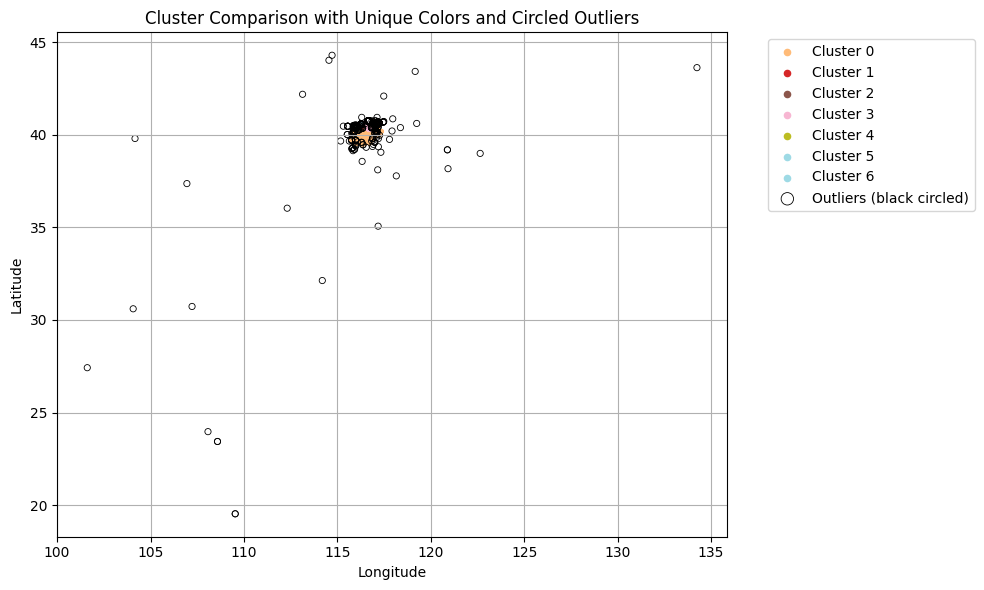

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(10, 6))

# Generate unique colors from a colormap
num_clusters = df_sample['cluster'].nunique() - (1 if -1 in df_sample['cluster'].unique() else 0)
colors = cm.get_cmap('tab20', num_clusters)  # use tab20 colormap

# Plot valid clusters with unique colors
cluster_labels = sorted(df_sample['cluster'].unique())
for i, label in enumerate(cluster_labels):
    if label == -1:
        continue
    cluster_points = df_sample[df_sample['cluster'] == label]
    plt.scatter(
        cluster_points['longitude'],
        cluster_points['latitude'],
        s=5,
        color=colors(i),
        label=f"Cluster {label}"
    )

# Plot outliers with dark outlined hollow dots
outliers = df_sample[df_sample['cluster'] == -1]
plt.scatter(
    outliers['longitude'],
    outliers['latitude'],
    s=20,
    facecolors='none',
    edgecolors='black',
    linewidths=0.6,
    label='Outliers (black circled)'
)

plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Cluster Comparison with Unique Colors and Circled Outliers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

**Finally Save Output**

In [9]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
filename = f"D:/Research/Papers/repo/IEEE_SubResizeUsingAIForFleetVehicles/Output/dbscan_cluster_outliers_{timestamp}.csv"
df_sample.to_csv(filename, index=False)